In [1]:
# =========================
#        COMUNES
# =========================
%load_ext autoreload
%autoreload 2

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

# Métricas generales
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# -------------------------
# Rutas del proyecto + escenario (nuevo)
# -------------------------
try:
    from educational_ai_analytics.config import (
        EMBEDDINGS_DATA_DIR,
        FEATURES_DATA_DIR,
        W_WINDOWS,
    )
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    FEATURES_ROOT = Path(FEATURES_DATA_DIR)
    WS_TO_PLOT = list(W_WINDOWS)
except ImportError:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    FEATURES_ROOT = Path("/workspace/TFM_education_ai_analytics/data/3_features")
    WS_TO_PLOT = [12, 18, 24]

SPLIT = "training"
TARGET_PATH = FEATURES_ROOT / SPLIT / "target.csv"

# -------------------------
# Nuevo escenario: day0 + acumulado uptoW (siempre)
# -------------------------
WITH_DAY0 = True  # ✅ escenario fijo: híbrido day0 + dinámicas

# -------------------------
# Week feature antes de emb/cluster (opcional)
# -------------------------
ADD_WEEK_FEATURE = True          # ✅ si apilas varias semanas en un mismo espacio
WEEK_FEATURE_MODE = "onehot"     # "onehot" o "numeric"

# -------------------------
# Parámetros globales de evaluación/plots
# -------------------------
SEED = 42
MAX_POINTS_PLOT = 30000
MAX_POINTS_METRICS = 30000

# -------------------------
# Estética y mapeo educativo (OULAD)
# -------------------------
COLORS_MAP = {3: "#FFD700", 2: "#4A79B7", 1: "#C54443", 0: "#E39063"}
LABELS_MAP = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}

# -------------------------
# Definición de métricas para tablas comparativas
# -------------------------
METRIC_DEFS = {
    'Silueta': ('Maximizar', 'Mide la separación y cohesión de los grupos (rango -1 a 1).'),
    'Calinski-Harabasz': ('Maximizar', 'Evalúa la dispersión entre clusters frente a la interna.'),
    'Davies-Bouldin': ('Minimizar', 'Indica la similitud media entre clusters (menos es mejor).')
}

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Target global
df_target = pd.read_csv(TARGET_PATH, index_col=0)
global_success_rate = (df_target["final_result"] >= 2).mean() * 100

print("✅ Variables globales listas.")
print(f"📊 Escenario: {'DAY0 + UPTOW' if WITH_DAY0 else 'SOLO UPTOW'}")
print(f"🧩 Week feature: {ADD_WEEK_FEATURE} | mode={WEEK_FEATURE_MODE if ADD_WEEK_FEATURE else '-'}")
print(f"🎯 Éxito global: {global_success_rate:.1f}% | Ventanas: {WS_TO_PLOT} | Split: {SPLIT}")


# ==========================================================
#              GMM (Gaussian Mixture Models)
# ==========================================================
from sklearn.mixture import GaussianMixture

GMM_K_RANGE = range(3, 7)          # n_components a probar
GMM_COV_TYPE = "full"              # "full", "diag", "tied", "spherical"
GMM_REG_COVAR = 1e-6               # estabiliza covarianza
GMM_MAX_ITER = 300
GMM_N_INIT = 5
GMM_INIT_PARAMS = "kmeans"         # "kmeans" o "random"
GMM_RANDOM_STATE = SEED

# Selección de K (opcional si quieres usar BIC/AIC)
GMM_USE_BIC = True
GMM_USE_AIC = False


# ==========================================================
#                      K-MEANS
# ==========================================================
from sklearn.cluster import KMeans

KM_K_RANGE = range(2, 10)
KM_K_FIXED = 5                     # si quieres fijar K
KM_N_INIT = 15                     # n_init alto = más estable
KM_MAX_ITER = 500
KM_ALGO = "lloyd"                  # "lloyd" o "elkan" (elkan suele acelerar euclídeo)
KM_RANDOM_STATE = SEED



✅ Variables globales listas.
📊 Escenario: DAY0 + UPTOW
🧩 Week feature: True | mode=onehot
🎯 Éxito global: 47.1% | Ventanas: [12, 18, 24] | Split: training


# 1. Clustering con K-means

### 📉 Análisis de Consistencia: **PCA**

⏳ Evaluando PCA | Semana 12...
⏳ Evaluando PCA | Semana 18...
⏳ Evaluando PCA | Semana 24...


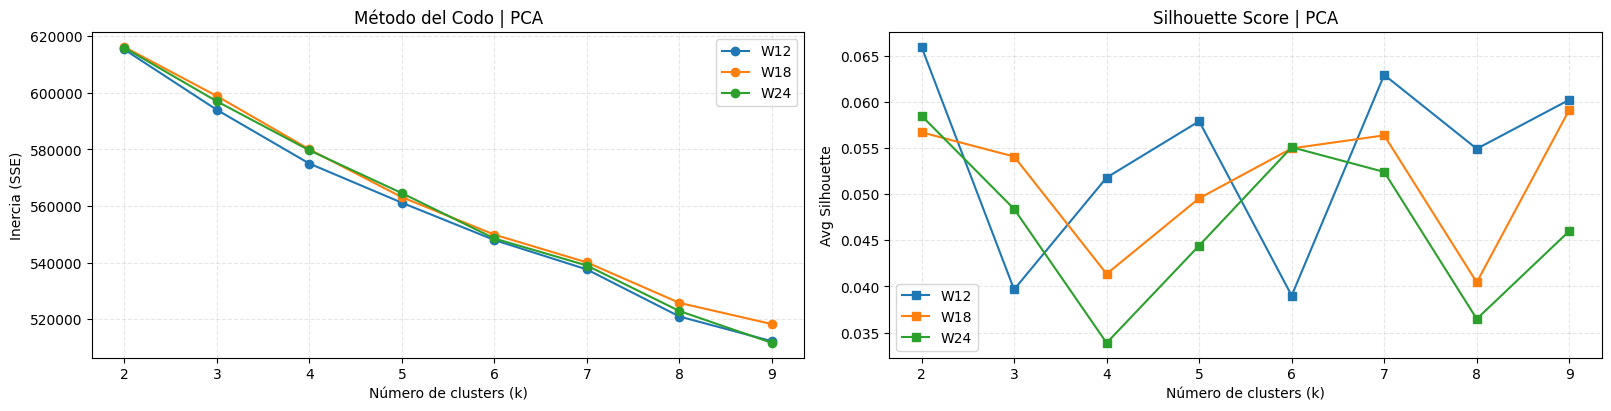

### 📉 Análisis de Consistencia: **AE**

⏳ Evaluando AE | Semana 12...
⏳ Evaluando AE | Semana 18...
⏳ Evaluando AE | Semana 24...


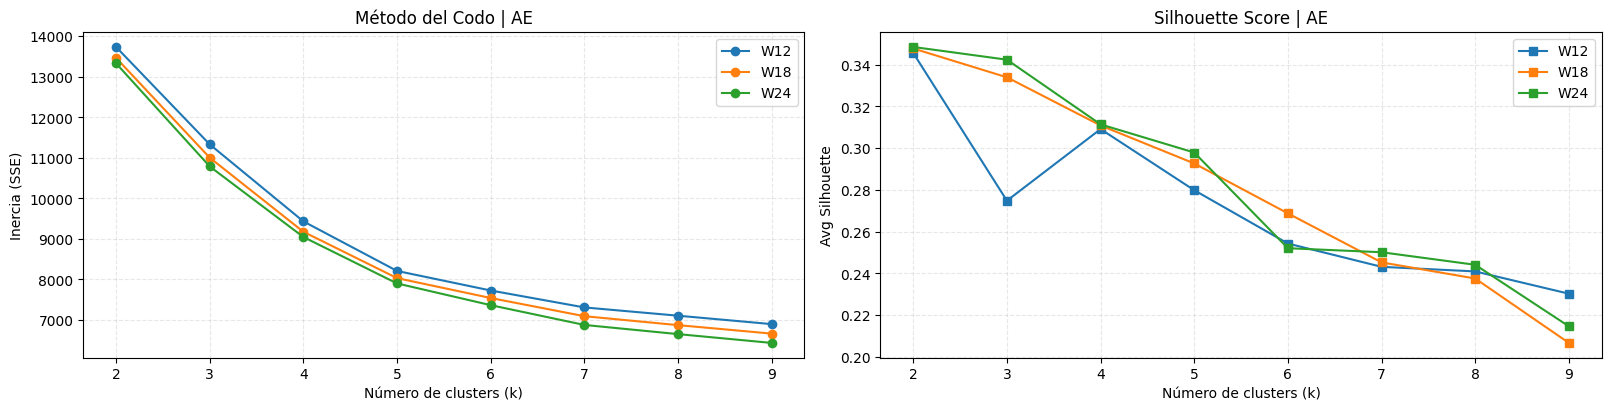

✅ Análisis finalizado.


In [2]:
# ==========================================================
# 📉 ELBOW + SILHOUETTE (Visualización Limpia)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

def _scale_X(X: np.ndarray, mode: str):
    X = np.asarray(X, dtype=np.float32)
    if mode == "none": return X
    elif mode == "standard": return StandardScaler().fit_transform(X).astype(np.float32)
    elif mode == "robust": return RobustScaler().fit_transform(X).astype(np.float32)
    elif mode == "l2": return Normalizer(norm="l2").fit_transform(X).astype(np.float32)
    else: raise ValueError(f"scale_mode inválido: {mode}")

def compute_elbow_metrics(X: np.ndarray, k_range, *, max_points_metrics: int, seed: int, n_init: int, max_iter: int, fit_on_subset: bool = True, scale_mode: str = "none"):
    X_scaled = _scale_X(X, scale_mode)
    n = len(X_scaled)
    if n > max_points_metrics:
        rng = np.random.RandomState(seed)
        idx = rng.choice(n, max_points_metrics, replace=False)
        X_sub = X_scaled[idx]
    else:
        X_sub = X_scaled

    inertias, silhouettes = [], []
    for k in k_range:
        km = KMeans(n_clusters=int(k), random_state=seed, n_init=n_init, max_iter=max_iter)
        if fit_on_subset:
            km.fit(X_sub)
            inertias.append(float(km.inertia_))
            silhouettes.append(float(silhouette_score(X_sub, km.labels_)))
        else:
            km.fit(X_scaled)
            inertias.append(float(km.inertia_))
            labels_sub = km.predict(X_sub)
            silhouettes.append(float(silhouette_score(X_sub, labels_sub)))
    return inertias, silhouettes

# ---------- Ejecución con configuraciones específicas ----------

EVAL_CONFIGS = [
    ("pca", "standard"),  
    ("ae", "l2"),        
]

for etype, scale_mode in EVAL_CONFIGS:
    display(Markdown(f"### 📉 Análisis de Consistencia: **{etype.upper()}**"))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), constrained_layout=True)

    for W in WS_TO_PLOT:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{etype}_latent.csv"
        df = safe_read_csv(path)
        if df.empty: continue

        print(f"⏳ Evaluando {etype.upper()} | Semana {W}...")

        X_data = df.values.astype(np.float32)
        vals_inert, vals_silh = compute_elbow_metrics(
            X_data, KM_K_RANGE, max_points_metrics=MAX_POINTS_METRICS,
            seed=SEED, n_init=KM_N_INIT, max_iter=KM_MAX_ITER,
            fit_on_subset=True, scale_mode=scale_mode
        )

        ax1.plot(list(KM_K_RANGE), vals_inert, marker="o", label=f"W{W}")
        ax2.plot(list(KM_K_RANGE), vals_silh, marker="s", label=f"W{W}")

    ax1.set_title(f"Método del Codo | {etype.upper()}")
    ax1.set_xlabel("Número de clusters (k)"); ax1.set_ylabel("Inercia (SSE)")
    ax1.grid(True, alpha=0.3, linestyle="--")
    ax1.legend()

    ax2.set_title(f"Silhouette Score | {etype.upper()}")
    ax2.set_xlabel("Número de clusters (k)"); ax2.set_ylabel("Avg Silhouette")
    ax2.grid(True, alpha=0.3, linestyle="--")
    ax2.legend()

    plt.show()

print("✅ Análisis finalizado.")

## Configuración particular K-MEans

### 🏁 Resultado (W24, K=5, StandardScaler)

,Valor PCA,Valor AE,Ganador
Métrica,,,
Silueta,0.0432,0.2587,AE 🚀
Calinski-Harabasz,740.9538,11815.8494,AE 🚀
Davies-Bouldin,3.6898,1.3245,AE 🚀


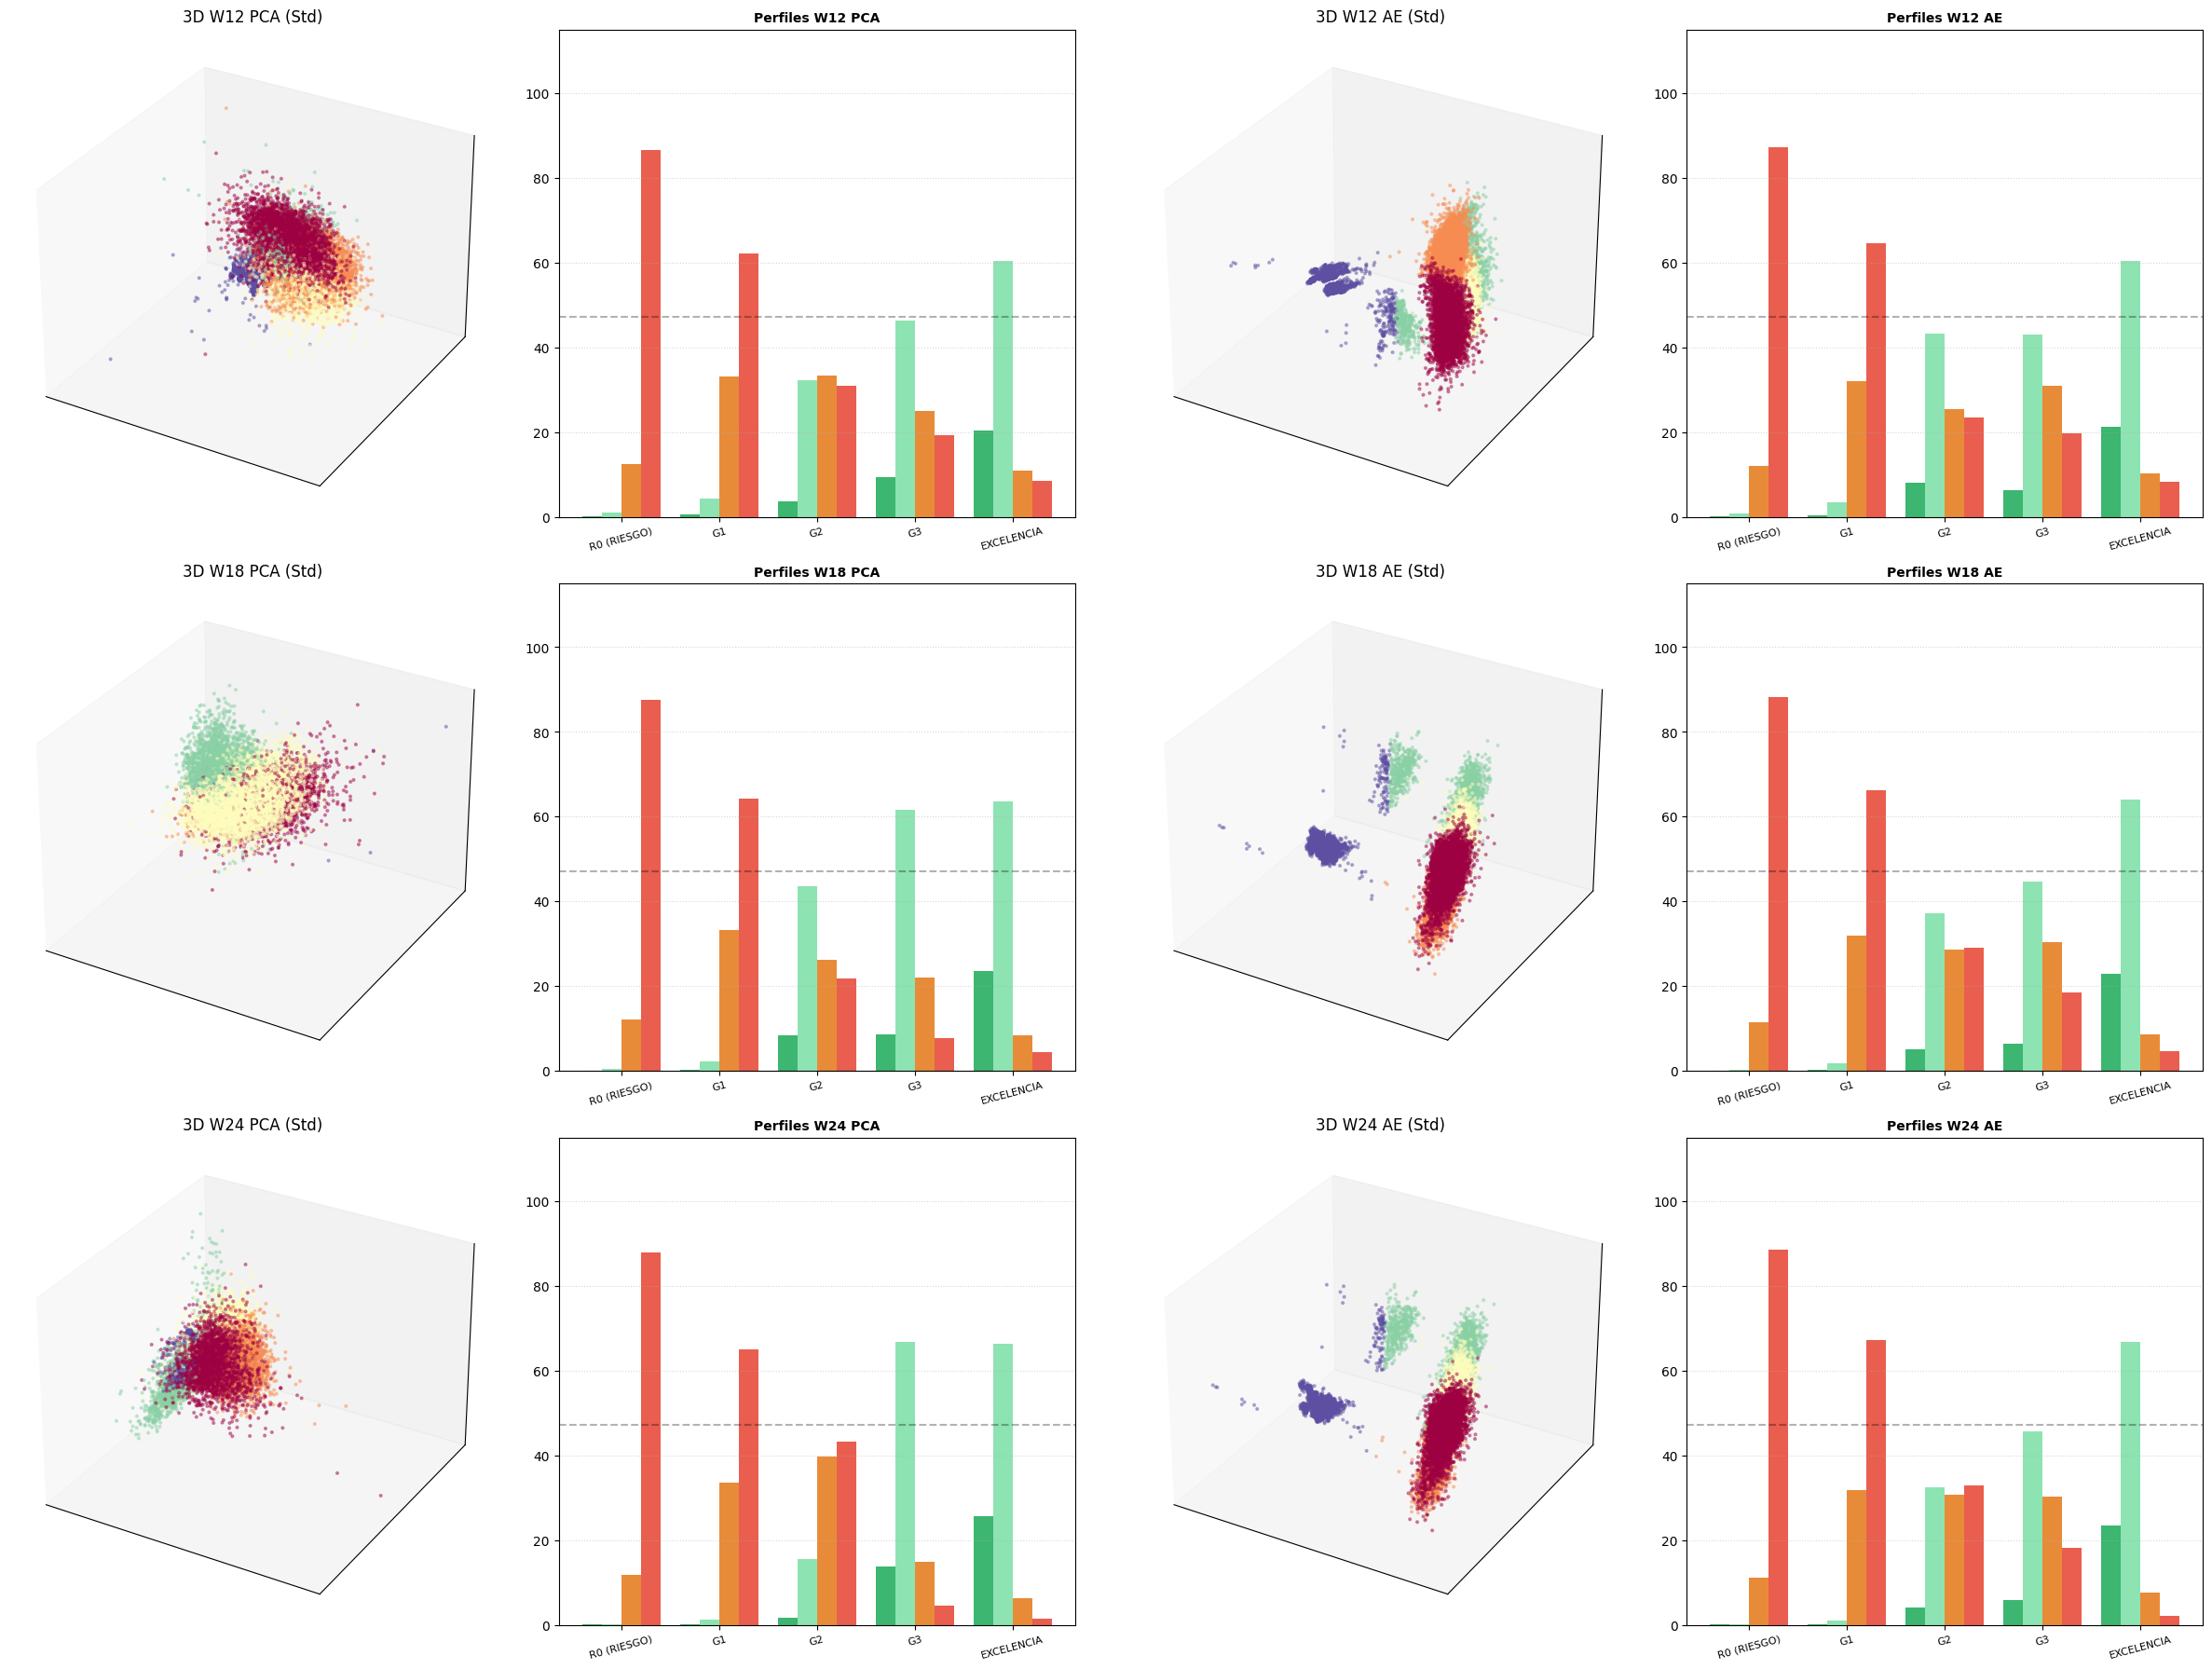

In [3]:
# ==========================================================
# 🎯 ANÁLISIS INTEGRADO (K-MEANS): DASHBOARD COMPLETO
#    - Incluye dibujo de barras + 3D + Métricas
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import importlib
from pathlib import Path
from IPython.display import display, Markdown

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Importamos la configuración del proyecto
from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, FEATURES_DATA_DIR, W_WINDOWS

warnings.filterwarnings("ignore")

# --- 1. CONFIGURACIÓN Y CARGA DE LABELS ---
SPLIT = "training"
LABELS_PATH = FEATURES_DATA_DIR / SPLIT / "target.csv"
labels_df = pd.read_csv(LABELS_PATH, index_col=0)

# Mapeos internos para que los gráficos salgan niquelados
LABELS_MAP = {0: "Withdrawn", 1: "Fail", 2: "Pass", 3: "Distinction"}
COLORS_MAP = {0: "#e74c3c", 1: "#e67e22", 2: "#82e0aa", 3: "#27ae60"} # Colores fijos

try:
    ae_mod = importlib.import_module("educational_ai_analytics.2_modeling.ae.hyperparams")
    AE_PARAMS = ae_mod.AE_PARAMS
except:
    class Dummy: n_clusters = 5; latent_dim = 28
    AE_PARAMS = Dummy()

K = AE_PARAMS.n_clusters
SEED = 42
N_INIT_KM = 15
WS_TO_PLOT = W_WINDOWS
ROOT = EMBEDDINGS_DATA_DIR
global_success_rate = (labels_df["final_result"] >= 2).mean() * 100

# --- 2. FUNCIONES DE DIBUJO Y PROCESADO ---
def plot_educational_bars(ax, df_combined, title, K, success_ref):
    """Dibuja el desglose de resultados académicos por cluster."""
    counts = df_combined.groupby(["cluster", "final_result"]).size().unstack(fill_value=0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    
    width = 0.2
    x = np.arange(len(percentages))
    # Aseguramos que siempre salgan los 4 resultados en el orden correcto
    for i, res_val in enumerate([3, 2, 1, 0]): 
        if res_val in percentages.columns:
            ax.bar(x + (i - 1.5) * width, percentages[res_val].values, width, 
                   label=LABELS_MAP[res_val], color=COLORS_MAP[res_val], alpha=0.9)
    
    ax.axhline(success_ref, color="black", linestyle="--", alpha=0.3)
    ax.set_title(title, fontsize=10, fontweight="bold")
    ax.set_xticks(x)
    labels = ["R0 (RIESGO)"] + [f"G{i}" for i in range(1, K-1)] + ["EXCELENCIA"]
    ax.set_xticklabels(labels[:K], fontsize=8, rotation=15)
    ax.set_ylim(0, 115)
    ax.grid(axis='y', linestyle=':', alpha=0.5)

def relabel_by_risk(labels, outcomes):
    """Ordena los clusters de mayor a menor riesgo de abandono."""
    tmp = pd.DataFrame({"cl": labels, "res": outcomes.values})
    risk = tmp.groupby("cl")["res"].apply(lambda x: (x == 0).mean()).sort_values(ascending=False)
    rmap = {old: new for new, old in enumerate(risk.index)}
    return np.array([rmap[c] for c in labels], dtype=int)

# ===========================
# 🚀 EJECUCIÓN DEL ANÁLISIS
# ===========================
results_storage, metrics_rows = {}, []

for W in WS_TO_PLOT:
    for etype in ["pca", "ae"]:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{etype}_latent.csv"
        if not path.exists(): continue
        df_l = pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        idx = labels_df.index.intersection(df_l.index)
        
        # Estandarización obligatoria y justa
        X_std = StandardScaler().fit_transform(df_l.loc[idx].values)
        
        km = KMeans(n_clusters=K, n_init=N_INIT_KM, random_state=SEED)
        cl_raw = km.fit_predict(X_std)
        cl_ord = relabel_by_risk(cl_raw, labels_df.loc[idx, "final_result"])

        results_storage[(W, etype)] = {"X_std": X_std, "cl_ord": cl_ord, "idx": idx}
        metrics_rows.append({
            "Semana": W, "Embedding": etype.upper(),
            "Silueta": silhouette_score(X_std, cl_raw, sample_size=5000, random_state=SEED),
            "CH": calinski_harabasz_score(X_std, cl_raw),
            "DB": davies_bouldin_score(X_std, cl_raw)
        })

# --- TABLA DE RESULTADOS ---
df_m = pd.DataFrame(metrics_rows)
last_w = WS_TO_PLOT[-1]
display(Markdown(f"### 🏁 Resultado (W{last_w}, K={K}, StandardScaler)"))
summary = []
for m, goal, label in [("Silueta", "max", "Silueta"), ("CH", "max", "Calinski-Harabasz"), ("DB", "min", "Davies-Bouldin")]:
    v_pca = df_m[(df_m["Semana"]==last_w) & (df_m["Embedding"]=="PCA")][m].values[0]
    v_ae = df_m[(df_m["Semana"]==last_w) & (df_m["Embedding"]=="AE")][m].values[0]
    winner = "PCA 📈" if (goal=="max" and v_pca > v_ae) or (goal=="min" and v_pca < v_ae) else "AE 🚀"
    summary.append({"Métrica": label, "Valor PCA": f"{v_pca:.4f}", "Valor AE": f"{v_ae:.4f}", "Ganador": winner})
display(pd.DataFrame(summary).set_index("Métrica"))

# --- DASHBOARD DE VISUALIZACIÓN ---
fig = plt.figure(figsize=(24, 6 * len(WS_TO_PLOT)))
for i, W in enumerate(WS_TO_PLOT):
    for j, etype in enumerate(["pca", "ae"]):
        key = (W, etype)
        if key not in results_storage: continue
        res = results_storage[key]
        
        # 1) Scatter 3D
        ax3 = fig.add_subplot(len(WS_TO_PLOT), 4, i*4 + j*2 + 1, projection="3d")
        Z3 = PCA(3, random_state=SEED).fit_transform(res["X_std"])
        ax3.scatter(Z3[:,0], Z3[:,1], Z3[:,2], c=res["cl_ord"], s=4, cmap="Spectral_r", alpha=0.4)
        ax3.set_title(f"3D W{W} {etype.upper()} (Std)"); ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
        
        # 2) Barras Educativas
        axb = fig.add_subplot(len(WS_TO_PLOT), 4, i*4 + j*2 + 2)
        df_bar = pd.DataFrame({
            "cluster": res["cl_ord"], 
            "final_result": labels_df.loc[res["idx"], "final_result"].values
        })
        plot_educational_bars(axb, df_bar, f"Perfiles W{W} {etype.upper()}", K, global_success_rate)

plt.tight_layout(); plt.show()

### 📉 BIC/AIC + mejora marginal | W24 | cov=full

#### PCA

,k,BIC,AIC,ΔBIC (k-1→k),ΔAIC (k-1→k),%ΔBIC,%ΔAIC
0,3,1.464021e+06,1.453545e+06,NaN,NaN,NaN,NaN
1,4,1.287623e+06,1.273652e+06,176398.0334,179892.7615,12.0489,12.3761
2,5,1.254241e+06,1.236775e+06,33382.4022,36877.1303,2.5926,2.8954
3,6,1.226297e+06,1.205337e+06,27943.8637,31438.5918,2.2280,2.5420


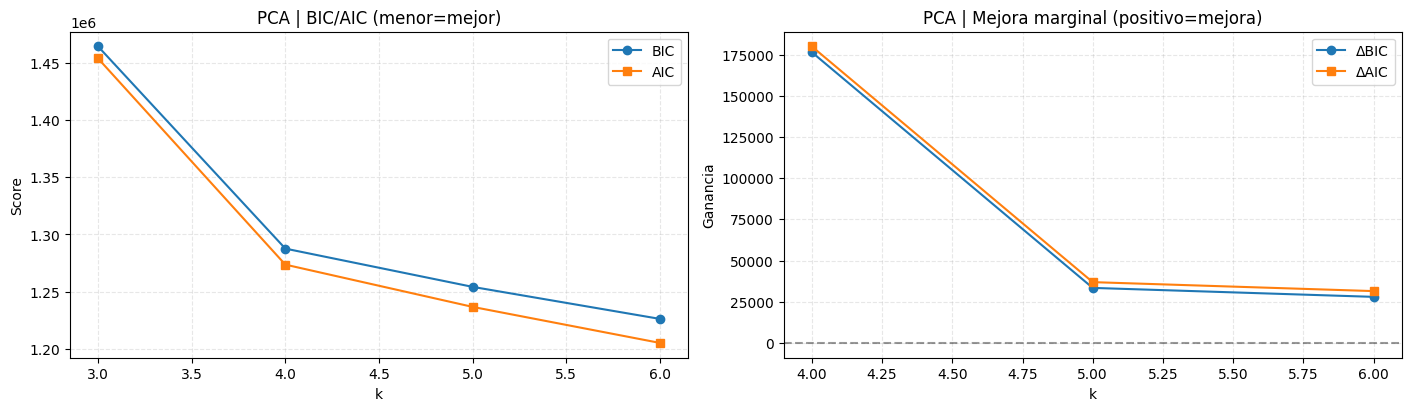

#### AE

,k,BIC,AIC,ΔBIC (k-1→k),ΔAIC (k-1→k),%ΔBIC,%ΔAIC
4,3,676796.2314,666320.0810,NaN,NaN,NaN,NaN
5,4,622082.7480,608111.8695,54713.4834,58208.2115,8.0842,8.7358
6,5,602800.5985,585334.9918,19282.1496,22776.8777,3.0996,3.7455
7,6,560235.8875,539275.5528,42564.7110,46059.4391,7.0612,7.8689


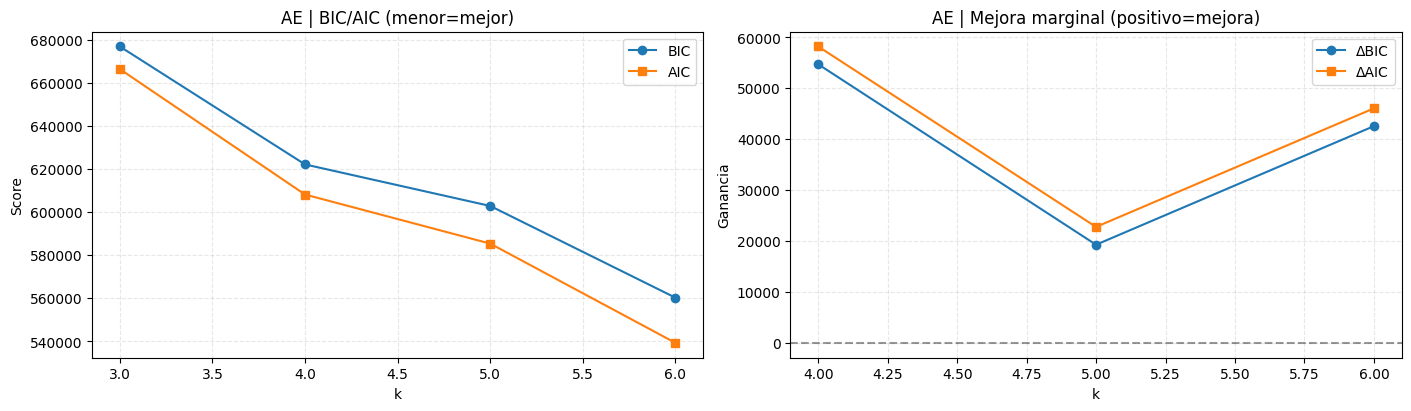

### ✅ k sugerido por mejora marginal

,Embedding,k_sugerido,criterio
0,PCA,6,mínimo BIC
1,AE,6,mínimo BIC


In [4]:
# ==========================================================
# 📉 BIC/AIC (PCA vs AE) + MEJORA MARGINAL POR K
#    - Menor es mejor (BIC/AIC)
##    - Mejora marginal = score(k-1) - score(k)
#      (positivo => mejorar al subir k)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# -------- Config rápida --------
W_BIC = WS_TO_PLOT[-1]                       # semana de referencia
EMB_TYPES = ["pca", "ae"]
K_RANGE = list(GMM_K_RANGE) if "GMM_K_RANGE" in globals() else list(range(2, 10))
COV_TYPE = GMM_COV_TYPE if "GMM_COV_TYPE" in globals() else "full"
REG_COV = GMM_REG_COVAR if "GMM_REG_COVAR" in globals() else 1e-6
N_INIT = GMM_N_INIT if "GMM_N_INIT" in globals() else 5
MAX_ITER = GMM_MAX_ITER if "GMM_MAX_ITER" in globals() else 300
SEED_LOCAL = SEED if "SEED" in globals() else 42

records = []
for emb_t in EMB_TYPES:
    path = ROOT / SPLIT / f"upto_w{W_BIC:02d}" / f"{emb_t}_latent.csv"
    df_l = safe_read_csv(path)
    if df_l.empty:
        continue

    # Estandarización consistente
    X = StandardScaler().fit_transform(df_l.values.astype(np.float32))

    prev_bic, prev_aic = None, None
    for k in K_RANGE:
        gmm = GaussianMixture(
            n_components=int(k),
            covariance_type=COV_TYPE,
            reg_covar=REG_COV,
            n_init=N_INIT,
            max_iter=MAX_ITER,
            random_state=SEED_LOCAL,
        )
        gmm.fit(X)

        bic_k = float(gmm.bic(X))
        aic_k = float(gmm.aic(X))

        # Mejora marginal: cuánto baja al subir de k-1 a k
        bic_gain = (prev_bic - bic_k) if prev_bic is not None else np.nan
        aic_gain = (prev_aic - aic_k) if prev_aic is not None else np.nan

        bic_gain_pct = (bic_gain / abs(prev_bic) * 100.0) if prev_bic not in (None, 0) else np.nan
        aic_gain_pct = (aic_gain / abs(prev_aic) * 100.0) if prev_aic not in (None, 0) else np.nan

        records.append({
            "Embedding": emb_t.upper(),
            "Semana": W_BIC,
            "k": int(k),
            "BIC": bic_k,
            "AIC": aic_k,
            "ΔBIC (k-1→k)": bic_gain,
            "ΔAIC (k-1→k)": aic_gain,
            "%ΔBIC": bic_gain_pct,
            "%ΔAIC": aic_gain_pct,
        })

        prev_bic, prev_aic = bic_k, aic_k

df_biaic = pd.DataFrame(records)
if df_biaic.empty:
    display(Markdown("⚠️ No se pudieron calcular BIC/AIC (faltan embeddings para la semana seleccionada)."))
else:
    display(Markdown(f"### 📉 BIC/AIC + mejora marginal | W{W_BIC} | cov={COV_TYPE}"))
    for emb_name in df_biaic["Embedding"].unique():
        d = df_biaic[df_biaic["Embedding"] == emb_name].copy().sort_values("k")

        # Resumen tabular
        show_cols = ["k", "BIC", "AIC", "ΔBIC (k-1→k)", "ΔAIC (k-1→k)", "%ΔBIC", "%ΔAIC"]
        disp = d[show_cols].copy()
        for c in ["BIC", "AIC", "ΔBIC (k-1→k)", "ΔAIC (k-1→k)", "%ΔBIC", "%ΔAIC"]:
            disp[c] = disp[c].map(lambda v: np.nan if pd.isna(v) else round(float(v), 4))

        display(Markdown(f"#### {emb_name}"))
        display(disp)

        # Plot score + mejora marginal
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

        ax1.plot(d["k"], d["BIC"], marker="o", label="BIC")
        ax1.plot(d["k"], d["AIC"], marker="s", label="AIC")
        ax1.set_title(f"{emb_name} | BIC/AIC (menor=mejor)")
        ax1.set_xlabel("k")
        ax1.set_ylabel("Score")
        ax1.grid(True, alpha=0.3, linestyle="--")
        ax1.legend()

        ax2.plot(d["k"], d["ΔBIC (k-1→k)"], marker="o", label="ΔBIC")
        ax2.plot(d["k"], d["ΔAIC (k-1→k)"], marker="s", label="ΔAIC")
        ax2.axhline(0.0, color="black", linestyle="--", alpha=0.4)
        ax2.set_title(f"{emb_name} | Mejora marginal (positivo=mejora)")
        ax2.set_xlabel("k")
        ax2.set_ylabel("Ganancia")
        ax2.grid(True, alpha=0.3, linestyle="--")
        ax2.legend()

        plt.show()

    # Recomendación simple por codo marginal (último k con mejora relevante)
    rec_rows = []
    for emb_name in df_biaic["Embedding"].unique():
        d = df_biaic[df_biaic["Embedding"] == emb_name].sort_values("k").copy()

        # Heurística: primer k donde %ΔBIC y %ΔAIC caen por debajo de 1%
        cond = (d["%ΔBIC"] < 1.0) & (d["%ΔAIC"] < 1.0)
        if cond.any():
            k_star = int(d.loc[cond, "k"].iloc[0])
            rule = "primer k con mejora marginal <1%"
        else:
            k_star = int(d.loc[d["BIC"].idxmin(), "k"])
            rule = "mínimo BIC"
        rec_rows.append({"Embedding": emb_name, "k_sugerido": k_star, "criterio": rule})

    display(Markdown("### ✅ k sugerido por mejora marginal"))
    display(pd.DataFrame(rec_rows))

🚀 Iniciando Evaluación (K=5, GMM cov=diag, n_init=10, Latente AE=N/A)...


### 🏁 Resultado (W24, K=5, GMM, StandardScaler, Latente AE=N/A)

,nombre metrica,valor PCA,valor AE,objetivo,ganador,descripcion
0,Silueta,-0.0060,0.2480,↑ MAX,AE 🚀,Cohesión vs separación (distancias). Más alto ...
1,Calinski-Harabasz,574.7397,11547.6346,↑ MAX,AE 🚀,Dispersión entre-clusters vs intra-cluster. Má...
2,Davies-Bouldin,4.5021,1.3376,↓ MIN,AE 🚀,Solape promedio entre clusters. Más bajo = clu...


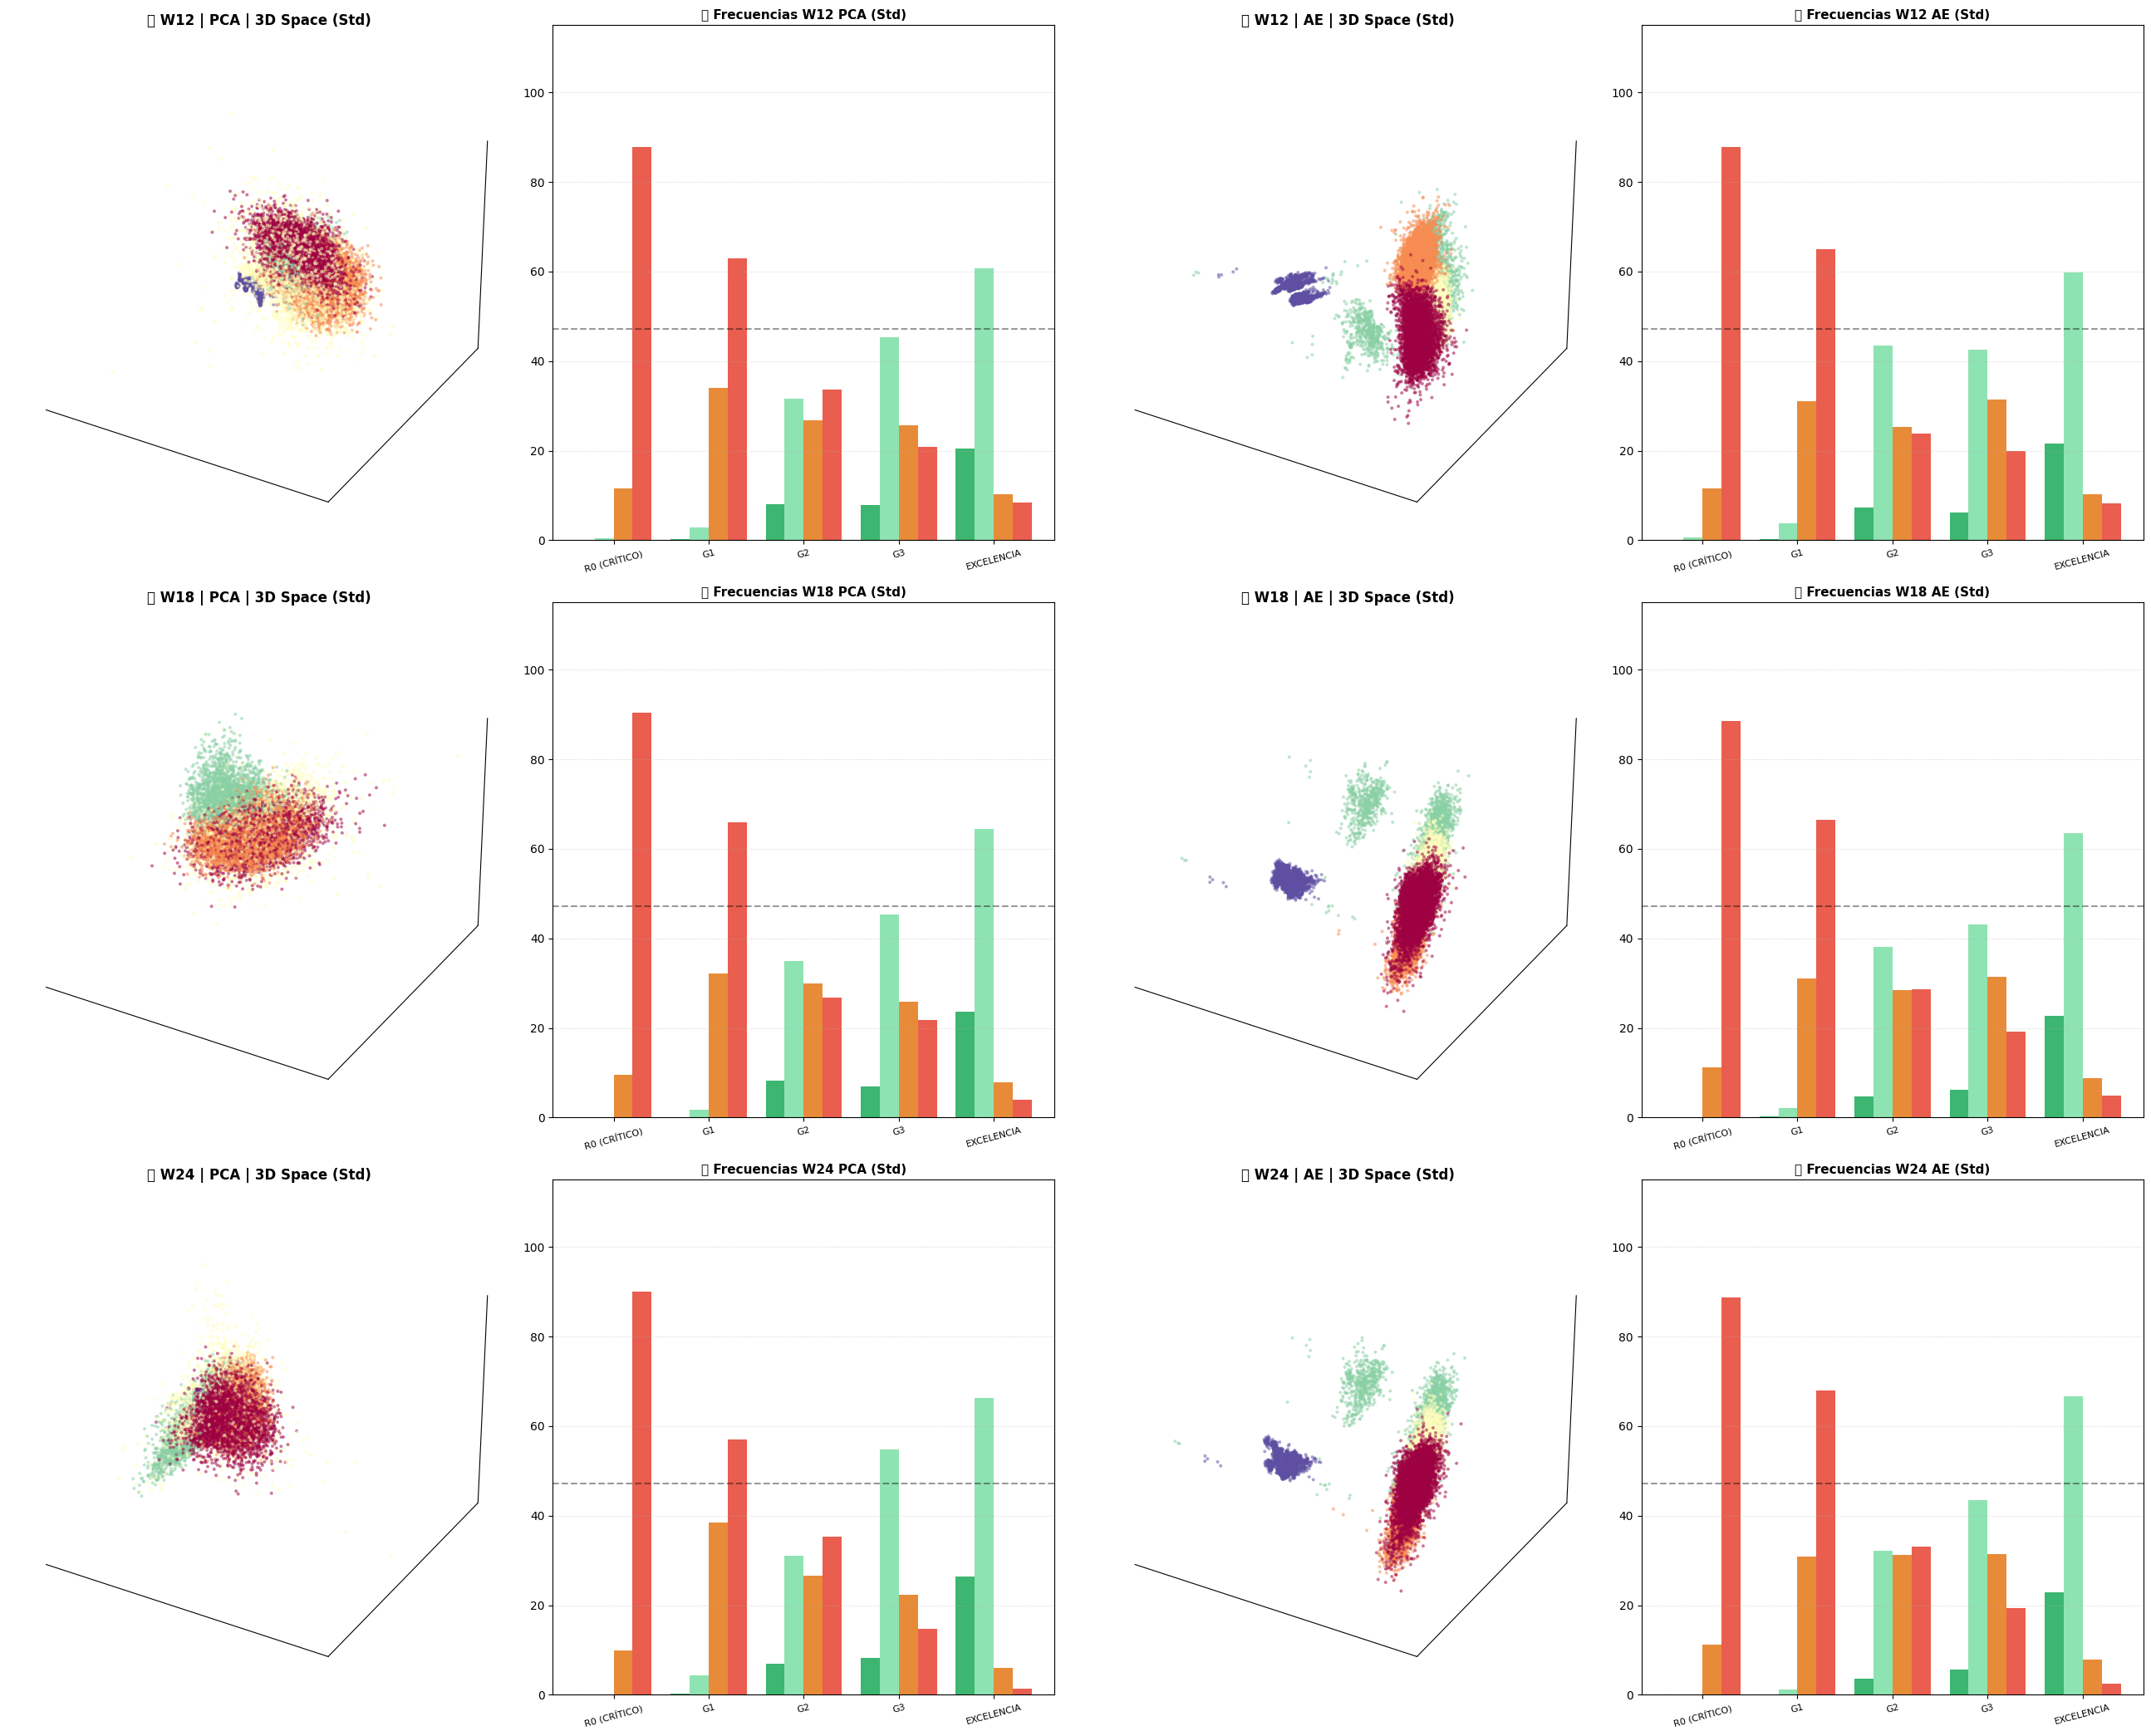

In [5]:
# ==========================================================
# 🎯 ANÁLISIS INTEGRADO (GMM): MÉTRICAS + DASHBOARD 3D
#    - StandardScaler consistente (PCA y AE por igual)
#    - K fijo
#    - Tabla con columnas:
#      nombre metrica | valor PCA | valor AE | objetivo | ganador | descripcion
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
from IPython.display import display, Markdown

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

warnings.filterwarnings("ignore")

# ---------------------------
# ⚙️ Config esperada (debe existir en tu notebook/proyecto)
#   ROOT, SPLIT, WS_TO_PLOT, SEED
#   safe_read_csv(path) -> DataFrame
#   df_target con columna "final_result"
#   LABELS_MAP (dict int->str) y COLORS_MAP (dict int->color)
# ---------------------------

# --- Parámetros de esta ejecución ---
K = KM_K_FIXED                   # reutilizamos tu K fijo (o cámbialo a mano)
EMB_TYPES = ["pca", "ae"]

# Parámetros GMM
GMM_COV = "diag"                 # "diag" suele ser estable en alta dim
GMM_N_INIT = 10
GMM_REG_COVAR = 1e-6

# Intentar leer dimensión latente AE (opcional)
try:
    from educational_ai_analytics.config import AE_LATENT_DIM
except Exception:
    AE_LATENT_DIM = "N/A"

# ---------------------------
# Helpers
# ---------------------------
def standardize(X: np.ndarray) -> np.ndarray:
    """Estandariza: media 0, var 1 (misma regla para PCA y AE)."""
    return StandardScaler().fit_transform(X)

def safe_silhouette(X: np.ndarray, labels: np.ndarray, seed: int, sample_max: int = 10000) -> float:
    """Silhouette robusto (evita crash si N pequeño o 1 cluster)."""
    if len(np.unique(labels)) < 2:
        return np.nan
    n = X.shape[0]
    ss_n = min(sample_max, n - 1)
    if ss_n <= 1:
        return np.nan
    return silhouette_score(X, labels, sample_size=ss_n, random_state=seed)

def relabel_by_risk(cluster_labels: np.ndarray, outcomes: pd.Series) -> np.ndarray:
    """
    Re-etiqueta clusters 0..K-1 ordenándolos por riesgo (Withdrawn=0) desc.
    Devuelve nuevos labels con 0=Riesgo (más withdraw), K-1=Excelencia (menos withdraw).
    """
    tmp = pd.DataFrame({"cl": cluster_labels, "res": outcomes.values})
    risk = tmp.groupby("cl")["res"].apply(lambda x: (x == 0).mean()).sort_values(ascending=False)
    rmap = {old: new for new, old in enumerate(risk.index)}
    return np.array([rmap[c] for c in cluster_labels], dtype=int)

def plot_educational_breakdown(ax, df_combined: pd.DataFrame, title: str, K: int, global_success_rate: float):
    """
    df_combined: columnas ["cluster", "final_result"] con cluster ya re-etiquetado (0..K-1)
    """
    counts = df_combined.groupby(["cluster", "final_result"]).size().unstack(fill_value=0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    width = 0.2
    x = np.arange(len(percentages))

    for i, res_val in enumerate([3, 2, 1, 0]):  # Distinction, Pass, Fail, Withdrawn
        if res_val in percentages.columns:
            ax.bar(
                x + (i - 1.5) * width,
                percentages[res_val].values,
                width,
                label=LABELS_MAP.get(res_val, str(res_val)),
                color=COLORS_MAP[res_val],
                alpha=0.9,
            )

    ax.axhline(global_success_rate, color="black", linestyle="--", alpha=0.4)
    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.set_xticks(x)

    labels = ["R0 (CRÍTICO)"] + [f"G{i}" for i in range(1, K - 1)] + ["EXCELENCIA"]
    ax.set_xticklabels(labels, fontsize=8, rotation=15)
    ax.set_ylim(0, 115)
    ax.grid(axis="y", linestyle=":", alpha=0.5)

# Especificación de métricas para tabla (formato pedido)
METRICS_SPEC = [
    {
        "nombre metrica": "Silueta",
        "objetivo": "↑ MAX",
        "descripcion": "Cohesión vs separación (distancias). Más alto = clusters más compactos y separados.",
        "fn": lambda X, cl: safe_silhouette(X, cl, SEED, sample_max=10000),
    },
    {
        "nombre metrica": "Calinski-Harabasz",
        "objetivo": "↑ MAX",
        "descripcion": "Dispersión entre-clusters vs intra-cluster. Más alto = mejor partición.",
        "fn": lambda X, cl: calinski_harabasz_score(X, cl) if len(np.unique(cl)) > 1 else np.nan,
    },
    {
        "nombre metrica": "Davies-Bouldin",
        "objetivo": "↓ MIN",
        "descripcion": "Solape promedio entre clusters. Más bajo = clusters más separados.",
        "fn": lambda X, cl: davies_bouldin_score(X, cl) if len(np.unique(cl)) > 1 else np.nan,
    },
]

def winner_from_objective(val_pca: float, val_ae: float, objetivo: str) -> str:
    if np.isnan(val_pca) or np.isnan(val_ae):
        return "N/A"
    if "MIN" in objetivo:
        return "PCA 📈" if val_pca < val_ae else "AE 🚀"
    return "PCA 📈" if val_pca > val_ae else "AE 🚀"

# ===========================
# 🚀 EJECUCIÓN
# ===========================
print(f"🚀 Iniciando Evaluación (K={K}, GMM cov={GMM_COV}, n_init={GMM_N_INIT}, Latente AE={AE_LATENT_DIM})...")

global_success_rate = (df_target["final_result"] >= 2).mean() * 100

results_storage = {}   # (W, emb) -> dict con X_std, cl_raw, cl_ord, idx
metrics_rows = []      # registros por semana/embedding/métrica

for W in WS_TO_PLOT:
    for emb_t in EMB_TYPES:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_t}_latent.csv"
        if not path.exists():
            continue

        df_l = safe_read_csv(path)
        idx_aligned = df_target.index.intersection(df_l.index)
        if len(idx_aligned) == 0:
            continue

        X = df_l.loc[idx_aligned].values.astype(np.float32)

        # ✅ StandardScaler (consistente para ambos)
        X_std = standardize(X)

        # GMM sobre datos estandarizados
        gmm = GaussianMixture(
            n_components=K,
            covariance_type=GMM_COV,
            n_init=GMM_N_INIT,
            reg_covar=GMM_REG_COVAR,
            random_state=SEED
        )
        cl_raw = gmm.fit_predict(X_std)

        # Re-etiquetado por riesgo (solo para dashboard interpretativo)
        outcomes = df_target.loc[idx_aligned, "final_result"]
        cl_ord = relabel_by_risk(cl_raw, outcomes)

        results_storage[(W, emb_t)] = {
            "X_std": X_std,
            "cl_raw": cl_raw,
            "cl_ord": cl_ord,
            "idx": idx_aligned
        }

        # Métricas internas (usar cl_raw; re-etiquetado no cambia nada)
        for spec in METRICS_SPEC:
            val = spec["fn"](X_std, cl_raw)
            metrics_rows.append({
                "Semana": W,
                "Embedding": emb_t.upper(),
                "nombre metrica": spec["nombre metrica"],
                "valor": val
            })

# ===========================
# 📋 TABLA COMPARATIVA (ÚLTIMA SEMANA)
# ===========================
df_metrics = pd.DataFrame(metrics_rows)
last_w = WS_TO_PLOT[-1]

display(Markdown(f"### 🏁 Resultado (W{last_w}, K={K}, GMM, StandardScaler, Latente AE={AE_LATENT_DIM})"))

table_rows = []
for spec in METRICS_SPEC:
    mname = spec["nombre metrica"]

    s_pca = df_metrics[(df_metrics["Semana"] == last_w) & (df_metrics["Embedding"] == "PCA") & (df_metrics["nombre metrica"] == mname)]["valor"]
    s_ae  = df_metrics[(df_metrics["Semana"] == last_w) & (df_metrics["Embedding"] == "AE")  & (df_metrics["nombre metrica"] == mname)]["valor"]

    v_pca = float(s_pca.values[0]) if not s_pca.empty else np.nan
    v_ae  = float(s_ae.values[0])  if not s_ae.empty else np.nan

    objetivo = spec["objetivo"]
    ganador = winner_from_objective(v_pca, v_ae, objetivo)

    table_rows.append({
        "nombre metrica": mname,
        "valor PCA": f"{v_pca:.4f}" if not np.isnan(v_pca) else "NaN",
        "valor AE": f"{v_ae:.4f}" if not np.isnan(v_ae) else "NaN",
        "objetivo": objetivo,
        "ganador": ganador,
        "descripcion": spec["descripcion"],
    })

df_table = pd.DataFrame(
    table_rows,
    columns=["nombre metrica", "valor PCA", "valor AE", "objetivo", "ganador", "descripcion"]
)
display(df_table)

# ===========================
# 🧊 DASHBOARD VISUAL 3D (todas las semanas)
# ===========================
fig = plt.figure(figsize=(26, 7 * len(WS_TO_PLOT)))

for i, W in enumerate(WS_TO_PLOT):
    for j, emb_t in enumerate(EMB_TYPES):
        key = (W, emb_t)
        if key not in results_storage:
            continue

        X_std = results_storage[key]["X_std"]
        cl_ord = results_storage[key]["cl_ord"]
        idx = results_storage[key]["idx"]

        # --- 3D scatter (PCA sobre X_std)
        ax_3d = fig.add_subplot(len(WS_TO_PLOT), 4, i * 4 + j * 2 + 1, projection="3d")
        Z3 = PCA(n_components=3, random_state=SEED).fit_transform(X_std)

        ax_3d.scatter(
            Z3[:, 0], Z3[:, 1], Z3[:, 2],
            c=cl_ord, s=4, cmap="Spectral_r", alpha=0.4
        )
        ax_3d.set_title(f"🚀 W{W} | {emb_t.upper()} | 3D Space (Std)", fontsize=12, fontweight="bold")
        ax_3d.set_xticks([]); ax_3d.set_yticks([]); ax_3d.set_zticks([])
        ax_3d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_3d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_3d.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        # --- barras por outcome
        ax_bar = fig.add_subplot(len(WS_TO_PLOT), 4, i * 4 + j * 2 + 2)
        plot_df = pd.DataFrame({
            "cluster": cl_ord,
            "final_result": df_target.loc[idx, "final_result"].values
        })
        plot_educational_breakdown(
            ax_bar,
            plot_df,
            f"📊 Frecuencias W{W} {emb_t.upper()} (Std)",
            K=K,
            global_success_rate=global_success_rate
        )

plt.tight_layout()
plt.show()

In [6]:
# ==========================================================
# 🗺️ MATRIZ DE INFLUENCIA (Z-EFFECT): CARACTERIZACIÓN FINAL
# ==========================================================
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# 1) Configuración y Carga Directa
W_PROFILE = WS_TO_PLOT[-1]
idx = results_storage[(W_PROFILE, "ae")]["idx"]
cl = results_storage[(W_PROFILE, "ae")]["cl_ord"]

# Carga de features originales
df_s = pd.read_csv(FEATURES_DATA_DIR / SPLIT / "day0_static_features.csv", index_col=0)
df_d = pd.read_csv(FEATURES_DATA_DIR / SPLIT / "ae_uptow_features" / f"ae_uptow_features_w{W_PROFILE:02d}.csv", index_col=0)
df_features = pd.concat([df_s, df_d.reindex(df_s.index)], axis=1).fillna(0.0)

# 2) Alineación y Cálculo
dfF = df_features.loc[idx].select_dtypes(include=[np.number])
if "final_result" in dfF.columns: dfF = dfF.drop(columns=["final_result"])

effect = (dfF.groupby(cl).mean() - dfF.mean()) / dfF.std().replace(0, 1.0)
effect = effect.sort_index()

# 3) Filtrado y Visualización (Solo Top 30 variables más discriminativas para que sea legible)
top_vars = (effect.max() - effect.min()).sort_values(ascending=False).head(30).index
matrix = effect[top_vars].T
matrix.columns = ["R0 (RIESGO)", "G1", "G2", "G3", "EXCELENCIA"]

display(Markdown(f"### 🧬 Matriz Z-Effect (Top 30 variables) | W{W_PROFILE}"))
display(matrix.style.background_gradient(cmap="RdYlGn", axis=1))

### 🧬 Matriz Z-Effect (Top 30 variables) | W24

,R0 (RIESGO),G1,G2,G3,EXCELENCIA
rel_eng_zscore,-2.127194,-0.992678,0.246570,0.204200,0.784487
total_weighted_engagement,-2.127194,-0.992678,0.246570,0.204200,0.784487
clicks_homepage,-2.006475,-1.040729,0.204622,0.121611,0.847780
activity_diversity,-2.129287,-0.902833,0.290502,0.249781,0.684972
temporal_entropy_uptoW,-1.741348,-1.307396,0.160738,0.120804,0.906037
clicks_subpage,-1.790348,-1.081923,0.193212,0.161503,0.779042
active_weeks,-1.478753,-1.256862,-0.029579,-0.032608,1.047446
active_ratio_uptoW,-1.478753,-1.256862,-0.029579,-0.032608,1.047446
weeks_since_last_activity,1.719326,1.297108,-0.175390,-0.302941,-0.774999
submission_count,-1.623574,-1.548060,0.227865,0.301361,0.803065


## 🧠 Perfiles detectados (W{W_PROFILE} | AE)

Estas etiquetas salen de la **matriz Z-Effect (variables × perfil)**:
- **> 0** = ese perfil está **por encima** de la media de la clase en esa variable  
- **< 0** = está **por debajo**  
- Nos fijamos sobre todo en las variables con más diferencia entre perfiles (**rango max–min**).

---

### 🟥 R0 (CRÍTICO) — *Desconectados / Riesgo de abandono*
**Lo que vemos (señales principales):**
- **Muy baja actividad y engagement:** `rel_eng_zscore`, `total_weighted_engagement`, `clicks_homepage`
- **Poca constancia:** `active_weeks`, `active_ratio_uptoW`, `activity_diversity`
- **Pocas entregas y bajo rendimiento:** `submission_count`, `avg_score`, `pass_ratio`
- **Mucha inactividad reciente:** `weeks_since_last_activity`, `weeks_since_last_submission`

**Etiqueta:** estudiantes que casi no participan y llevan tiempo sin actividad/entregas.

---

### 🟧 G1 — *Curiosos intermitentes*
**Lo que vemos:**
- **Interés temprano alto:** `curiosity_index`, `early_weeks_ratio`
- **Pero no consolidan rutina:** engagement/entregas bajas (`submission_count`, `has_submitted`)
- **Parones frecuentes:** `weeks_since_last_activity` alto

**Etiqueta:** entran, exploran y miran… pero no mantienen constancia.

---

### 🟨 G2 — *Irregulares / “cumplen lo justo”*
**Lo que vemos:**
- **Rendimiento medio:** `avg_score`, `pass_ratio` ligeramente por encima o cerca de la media
- **Actividad poco estable:** `active_weeks`, `active_ratio_uptoW` alrededor de media o algo bajos
- **Evolución variable:** `score_slope`, `effort_slope` con cambios (suben/bajan)

**Etiqueta:** aparecen por hitos y entregan a ratos, pero sin hábito claro.

---

### 🟩 G3 — *Constantes en progreso*
**Lo que vemos:**
- **Más constancia y actividad:** `active_weeks`, `active_ratio_uptoW`
- **Más señales de trabajo real:** `submission_count`, `api_index`
- **Más recencia (están “presentes”):** `weeks_since_last_activity` bajo
- **Mejor rendimiento:** `avg_score`, `pass_ratio` por encima

**Etiqueta:** estudiantes con rutina razonable y trayectoria positiva.

---

### 🟩⭐ EXCELENCIA — *Alto rendimiento sostenido*
**Lo que vemos:**
- **Engagement alto y diverso:** `rel_eng_zscore`, `clicks_*`, `activity_diversity`
- **Constancia fuerte (rachas):** `streak_max_uptoW`, `streak_final`, `weekly_std_uptoW`
- **Rendimiento alto:** `avg_score`, `pass_ratio`
- **Actividad reciente:** baja `weeks_since_last_*`

**Etiqueta:** participación constante + buen rendimiento, sin desconexiones.

---

### 🔎 Variables clave que más “explican” las diferencias
- **Engagement:** `rel_eng_zscore`, `total_weighted_engagement`, `clicks_*`
- **Constancia/actividad:** `active_weeks`, `active_ratio_uptoW`, `streak_*`, `weekly_std_uptoW`
- **Recencia (inactividad):** `weeks_since_last_activity`, `weeks_since_last_submission`
- **Entregas:** `submission_count`, `has_submitted`
- **Rendimiento:** `avg_score`, `pass_ratio`
- **Exploración temprana:** `curiosity_index`, `early_weeks_ratio`


In [7]:
# ==========================================================
# 🏷️ ETIQUETADO AUTOMÁTICO DE CLUSTERS (reglas + evidencia)
#   - Usa la matriz effect (Feature x Perfil) si existe
#   - Si no existe, la reconstruye desde df_features_full + idx + cl
#   - Devuelve:
#       1) Tabla resumen por cluster con etiqueta sugerida + drivers
#       2) Diccionario cluster_id -> etiqueta
# ==========================================================
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# ---------------------------
# 0) Preconditions / reconstrucción de effect si no existe
# ---------------------------
assert "df_features_full" in globals(), "Necesito df_features_full (features estáticas+dinámicas)."
assert "idx" in globals() and "cl" in globals(), "Necesito idx y cl (clusters)."

# Si venías de la celda "matriz", probablemente tienes W_PROFILE/EMB_PROFILE/labels_perfil
W_PROFILE = globals().get("W_PROFILE", WS_TO_PLOT[-1])
EMB_PROFILE = globals().get("EMB_PROFILE", "ae")

# Reconstruimos effect (Feature x Cluster) si no está
if "effect" not in globals() or not isinstance(globals()["effect"], pd.DataFrame):
    dfF = df_features_full.loc[idx].copy()
    dfF = dfF.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    if "final_result" in dfF.columns:
        dfF = dfF.drop(columns=["final_result"])

    global_mean = dfF.mean(axis=0)
    global_std = dfF.std(axis=0).replace(0, np.nan)

    cluster_means = dfF.groupby(cl).mean()
    effect_cf = (cluster_means - global_mean) / global_std
    effect_cf = effect_cf.replace([np.inf, -np.inf], np.nan).fillna(0.0).sort_index()

    effect = effect_cf.T  # Feature x Cluster

K_eff = effect.shape[1]

# Etiquetas base por orden (0 riesgo ... K-1 éxito)
labels_perfil = globals().get(
    "labels_perfil",
    ["R0 (CRÍTICO)"] + [f"G{i}" for i in range(1, K_eff - 1)] + ["EXCELENCIA"]
)
if len(labels_perfil) != K_eff:
    labels_perfil = [f"Grupo {i}" for i in range(K_eff)]
    if K_eff > 1:
        labels_perfil[0] += " (RIESGO)"
        labels_perfil[-1] += " (ÉXITO)"

# Asegurar columnas con nombres de perfil (solo estético)
effect_named = effect.copy()
effect_named.columns = labels_perfil

# ---------------------------
# 1) Definir “familias” de features (por prefijos / contains)
#    Ajusta estos patrones a tus nombres reales si hace falta.
# ---------------------------
PATTERNS = {
    "engagement": ["eng", "engagement", "weighted_engagement", "rel_eng"],
    "clicks": ["click"],
    "diversity": ["diversity"],
    "activity": ["active_", "activity_", "weeks_", "ratio_", "weekly_"],
    "recency_inactive": ["weeks_since_last_activity", "weeks_since_last_submission"],
    "streak": ["streak"],
    "performance": ["avg_score", "pass_ratio", "score", "grade"],
    "curiosity": ["curiosity"],
    "submissions": ["submission", "has_submitted"],
    "quizzes": ["quiz"],
    "forum": ["forum"],
}

def cols_matching(df: pd.DataFrame, patterns) -> list[str]:
    cols = []
    for c in df.index:  # df is effect with index=features
        lc = c.lower()
        if any(p in lc for p in patterns):
            cols.append(c)
    return cols

FAMILY_COLS = {fam: cols_matching(effect_named, pats) for fam, pats in PATTERNS.items()}

def family_score(effect_df: pd.DataFrame, colname: str, fam: str) -> float:
    """Score medio de z-effect para una familia en un perfil."""
    cols = FAMILY_COLS.get(fam, [])
    if not cols:
        return 0.0
    return float(effect_df.loc[cols, colname].mean())

# ---------------------------
# 2) Reglas de etiquetado (heurísticas claras)
#    - Funcionan bien si tus features siguen nombres parecidos a los de tu tabla.
# ---------------------------
def propose_label(effect_df: pd.DataFrame, colname: str) -> tuple[str, list[tuple[str, float]]]:
    """
    Devuelve (etiqueta, drivers), donde drivers son scores por familia para justificar.
    """
    fam_scores = {fam: family_score(effect_df, colname, fam) for fam in FAMILY_COLS.keys()}

    # Drivers principales (top 5 por |score|)
    drivers = sorted(fam_scores.items(), key=lambda kv: abs(kv[1]), reverse=True)[:5]

    # Atajos útiles
    eng = fam_scores.get("engagement", 0.0) + fam_scores.get("clicks", 0.0)
    perf = fam_scores.get("performance", 0.0)
    streak = fam_scores.get("streak", 0.0)
    rec = fam_scores.get("recency_inactive", 0.0)   # ojo: + alto suele = más inactividad (peor)
    div = fam_scores.get("diversity", 0.0)
    cur = fam_scores.get("curiosity", 0.0)
    subs = fam_scores.get("submissions", 0.0)

    # --- Reglas (ajusta umbrales si quieres) ---
    if eng < -0.8 and rec > 0.6:
        label = "Desconectados / Riesgo de abandono"
    elif cur > 0.6 and eng < -0.3 and rec > 0.2:
        label = "Curiosos intermitentes / Exploradores"
    elif eng < -0.2 and perf >= -0.1 and rec <= 0.3:
        label = "Oportunistas / Cumplen lo justo"
    elif eng > 0.3 and perf > 0.2 and (div > 0.1 or subs > 0.1) and rec < 0.0:
        label = "Constantes en progreso"
    elif eng > 0.8 and perf > 0.5 and (streak > 0.4 or subs > 0.3) and rec < -0.2:
        label = "Excelencia / Alto rendimiento sostenido"
    else:
        # fallback “neutro” basado en signo global
        overall = float(effect_df[colname].mean())
        if overall > 0.2:
            label = "Perfil activo (por encima de la media)"
        elif overall < -0.2:
            label = "Perfil de baja actividad (por debajo de la media)"
        else:
            label = "Perfil mixto / intermedio"

    return label, drivers

# ---------------------------
# 3) Generar tabla de etiquetas + evidencia (drivers + top features)
# ---------------------------
TOP_FEATS_PER_CLUSTER = 6

rows = []
cluster_to_label = {}

for prof in effect_named.columns:
    label, drivers = propose_label(effect_named, prof)
    cluster_to_label[prof] = label

    # Top features positivas/negativas del perfil
    s = effect_named[prof].sort_values(ascending=False)
    top_pos = list(s.head(TOP_FEATS_PER_CLUSTER).items())
    top_neg = list(s.tail(TOP_FEATS_PER_CLUSTER).sort_values().items())

    rows.append({
        "perfil": prof,
        "etiqueta_sugerida": label,
        "drivers_familia (score medio z)": ", ".join([f"{k}:{v:+.2f}" for k, v in drivers]),
        "top + features": ", ".join([f"{k}({v:+.2f})" for k, v in top_pos]),
        "top - features": ", ".join([f"{k}({v:+.2f})" for k, v in top_neg]),
    })

df_labels = pd.DataFrame(rows)

display(Markdown(f"### 🏷️ Etiquetas automáticas por perfil | W{W_PROFILE} | {EMB_PROFILE.upper()}"))
display(df_labels)

display(Markdown("### 🧷 Diccionario perfil → etiqueta (para usar en plots/reporte)"))
display(pd.Series(cluster_to_label, name="etiqueta").to_frame())

# Si además quieres un mapping numérico (cluster_id) y no el nombre de columna,
# aquí te lo dejo por si usas columnas como R0/G1/...
# (Si prefieres cluster_id 0..K-1, cambia keys por range(K_eff))
mapping_for_use = {i: cluster_to_label[labels_perfil[i]] for i in range(K_eff)}
display(Markdown("### 🔁 mapping cluster_id → etiqueta (0..K-1)"))
display(pd.Series(mapping_for_use, name="etiqueta").to_frame())


AssertionError: Necesito df_features_full (features estáticas+dinámicas).